# Submission 3

Joe Hoong Ng (ng_joehoong@hotmail.com)

Dang Duy Nghia Nguyen (nghia002@e.ntu.edu.sg)

Dylan Thorne (dylan.thorne@gmail.com)

Zain Us Sami Ahmed Ansari (zainussami@gmail.com)	



In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import scipy.optimize

import math
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1 
Using a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and
counterparty firm values. You should simulate the values monthly, and should have LIBOR
forward rates applying over one month, starting one month apart, up to maturity. You may
assume that the counterparty firm and stock values are uncorrelated with LIBOR forward
rates

In [3]:
### Initialize problem parameters
T = 1 # option maturity
L = 150 # up-and-out barrier
S0 = 100 # current share price
K = 100 # strike price, at-the-money


v_0 = 200 # counterparty firm current value
debt = 175 # counterparty's debt, due in one year 
corr = .2 # correlation
recovery_rate = 0.25 # recovery rate
########

corr_matrix = np.array([[1, corr], [corr, 1]])
sample_size = 1000

In [4]:
sigma_const = 0.30
gamma = 0.75

## Calibrate LIBOR forward rate model from zero coupon bond prices

In [5]:
t = np.linspace(0,1,13)

market_zcb_prices = np.array([1.0, 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 0.9516,
       0.9457, 0.9399, 0.9342, 0.9285])



In [6]:
def A(t1, t2, alpha):
    return (1-np.exp(-alpha*(t2-t1)))/alpha
def D(t1, t2, alpha, b, sigma):
    val1 = (t2-t1-A(t1,t2,alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return val1-val2

def bond_price_fun(r,t,T, alpha, b, sigma):
    return np.exp(-A(t,T,alpha)*r+D(t,T,alpha,b,sigma))

#r0 = 0.05

def F(x):
    alpha = x[0]
    b = x[1]
    sigma = x[2]
    r0 = x[3]
    return sum(np.abs(bond_price_fun(r0,0,t,alpha,b,sigma)-market_zcb_prices))

In [7]:
#minimizing F
bnds = ((0,1),(0,0.2),(0,0.2), (0.00,0.10))
opt_val = scipy.optimize.fmin_slsqp(F, (0.3, 0.05, 0.03, 0.05), bounds=bnds)
opt_alpha = opt_val[0]
opt_b = opt_val[1]
opt_sigma = opt_val[2]
opt_r0 = opt_val[3]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00025649906704716674
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 10


In [8]:
print("Optimal alpha: {:.3f}".format(opt_val[0]))
print("Optimal b: {:.3f}".format(opt_val[1]))
print("Optimal sigma {:.3f}".format(opt_val[2]))
print("Optimal r0: {:.3f}".format(opt_val[3]))

Optimal alpha: 0.273
Optimal b: 0.069
Optimal sigma 0.028
Optimal r0: 0.075


C:\Users\ng_jo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


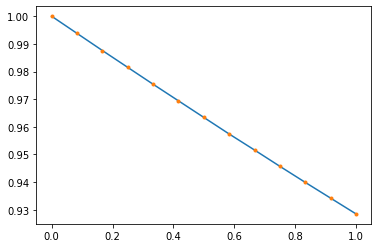

In [9]:
model_prices = bond_price_fun(opt_r0,0,t, opt_alpha, opt_b, opt_sigma)
model_yield = -np.log(model_prices)/t

plt.plot(t,market_zcb_prices)
plt.plot(t, model_prices, '.')
plt.show()


## Simulate LIBOR rate paths 

In [10]:
t = np.linspace(0,1,13)
sigmaj = 0.2

We use paramters we obtained above to recreate the Vasicek bond prices:

In [11]:
def A(t1, t2):
    return (1-np.exp(-opt_alpha*(t2-t1)))/opt_alpha

def C(t1, t2):
    val1 = (t2-t1-A(t1,t2))*(opt_sigma**2/(2*opt_alpha**2)-opt_b)
    val2 = opt_sigma**2*A(t1,t2)**2/(4*opt_alpha)
    return val1 - val2

def bond_price(r,t,T):
    return np.exp(-A(t,T)*r+C(t,T))

vasi_bond = bond_price(opt_r0, 0, t)

The prices calculated from the Vasicek model are close to the ZCB prices given by the assignment:

In [12]:
print(vasi_bond)

[1.         0.99377572 0.98760087 0.98147516 0.97539831 0.96936998
 0.96338983 0.95745752 0.95157266 0.94573489 0.93994381 0.93419901
 0.9285001 ]


We now initialize the matrices we will use to store the Monte Carlo simulations, for both basic Monte Carlo and Predictor-Corrector method.

In [13]:
n_simulations = 1000
n_steps = len(t)

mc_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_capfac = np.ones([n_simulations, n_steps])
mc_capfac = np.ones([n_simulations, n_steps])

delta = np.ones([n_simulations, n_steps - 1])*(t[1:]-t[:-1])

We now run the Monte Carlo simulation for each time step:

In [14]:
for i in range(1, n_steps):
    Z = norm.rvs(size=[n_simulations,1])
    
    muhat = np.cumsum(delta[:, i:]*mc_forward[:, i:]*sigmaj**2/(1+delta[:, i:]*mc_forward[:,i:]), axis=1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]), axis=1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp), axis=1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z)

From our Monte Carlo simulation, we now calculate the capitalization factors and bond prices, and plot them to compare them with the Vasicek bond prices.

In [15]:
mc_capfac[:,1:] = np.cumprod(1+mc_forward, axis=1)
predcorr_capfac[:,1:] = np.cumprod(1+predcorr_forward, axis=1)

mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

mc_final = np.mean(mc_price, axis=0)
predcorr_final = np.mean(predcorr_price, axis=0)

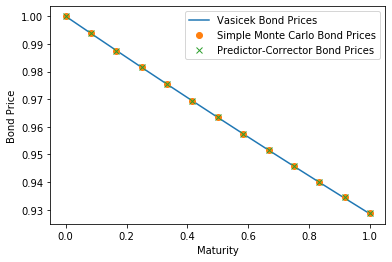

In [16]:
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t,vasi_bond, label="Vasicek Bond Prices")

plt.plot(t, mc_final, 'o', label="Simple Monte Carlo Bond Prices")
plt.plot(t, predcorr_final, 'x', label="Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

From our simulation of forward rates (we take the Predictor-Corrector method, we use the formula $e^{r_{t_i} (t_{i+1}-t_i)} = 1 + L(t_i,t_{i+1})(t_{i+1}-t_i)$ to obtain the continuous compounded interest rates:

In [29]:
r_sim = np.log(1 + predcorr_forward*(delta))/delta

In [35]:
r_sim_annualized = r_sim/delta

In [36]:
r_sim_annualized

array([[0.07513961, 0.07249492, 0.07740791, ..., 0.07906522, 0.08199103,
        0.08932798],
       [0.07513961, 0.08076996, 0.08782098, ..., 0.11550438, 0.11036754,
        0.11753835],
       [0.07513961, 0.07524248, 0.07011515, ..., 0.04673982, 0.04963255,
        0.05439583],
       ...,
       [0.07513961, 0.07318731, 0.06644472, ..., 0.07953647, 0.07874541,
        0.07980891],
       [0.07513961, 0.07821143, 0.0724958 , ..., 0.05431631, 0.05583123,
        0.05520989],
       [0.07513961, 0.07669614, 0.06987454, ..., 0.07001023, 0.07259048,
        0.06931136]])

## Generate stock and firm values

In [37]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, Z, varying_vol = True):

    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)

    return prev_price*np.exp((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z)



In [38]:


def generate_share_and_firm_price(S0, v_0, r_sim, sigma_const, gamma, corr, T, sample_size, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    
    share_price_path = pd.DataFrame(next_share_price(S0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,0,]))
    share_price_path = share_price_path.transpose()
    
    first_row = pd.DataFrame([S0]*sample_size)
    first_row = first_row.transpose()
    share_price_path = pd.concat([first_row, share_price_path])

    firm_price_path = pd.DataFrame(next_share_price(v_0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,1,]))
    firm_price_path = firm_price_path.transpose()
    
    first_row = pd.DataFrame([v_0]*sample_size)
    first_row = first_row.transpose()
    firm_price_path = pd.concat([first_row, firm_price_path])

    return [share_price_path,firm_price_path]  

In [43]:

share_prices, firm_prices = generate_share_and_firm_price(S0, v_0, r_sim_annualized[:,:], sigma_const, gamma, corr, T, sample_size, timesteps = 12)

In [44]:
share_prices

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0,101.685271,105.608377,98.750178,103.831900,97.848572,105.546361,104.809910,96.492553,94.450898,102.446569,...,99.223377,98.410870,100.491701,103.494317,98.717926,101.212581,100.977424,100.244475,100.421156,100.330679
1,101.439289,99.646692,98.914384,99.482205,105.542063,104.578892,100.180785,101.878648,97.647468,101.256798,...,99.354730,101.745730,105.105774,97.780332,97.056836,98.611051,93.305816,102.447509,95.649858,94.720119
2,97.946513,106.058968,97.936846,103.058880,97.755986,102.280110,98.668081,99.143936,97.732256,99.309416,...,107.325951,99.738790,99.472103,103.589845,97.394400,99.197636,100.132125,99.599009,100.023277,101.128481
3,101.527436,100.454130,98.242894,105.395132,99.623574,100.423923,100.617232,101.735197,104.561008,101.429600,...,102.228528,96.482400,101.188730,98.247308,102.548893,101.617029,108.019773,102.569250,104.030801,105.697386
4,97.525499,100.454204,100.641396,98.290897,104.382544,99.481531,100.163954,96.420292,99.085444,100.502537,...,101.771946,100.114086,100.629622,105.244857,104.390823,100.639725,101.437582,98.024616,99.612709,96.870126
5,98.260030,102.444381,98.700888,104.041503,103.286669,98.467846,101.640768,98.041333,99.376947,96.479066,...,97.093370,99.847406,97.693221,102.089277,101.180548,101.052422,99.064828,104.067698,97.265151,96.630542
6,103.775359,101.362287,104.630802,100.348461,103.155102,100.873442,104.436603,100.186444,99.979278,98.379587,...,102.942321,102.916317,99.948432,101.760732,108.495957,96.534218,99.311997,100.271806,95.403948,104.911237
7,100.972130,105.600852,103.328705,101.197458,103.798643,101.707513,103.319967,98.999969,99.885531,100.228692,...,101.413446,98.492811,97.042956,101.226050,97.405030,99.858129,100.475808,102.496362,97.874138,97.720044
8,98.397058,101.002888,103.722079,109.986057,101.407815,103.753031,106.945744,102.818396,102.911199,99.695337,...,99.051328,104.551702,100.428041,100.867586,105.123375,104.043071,103.974808,99.989308,102.158151,98.533505


In [45]:
firm_prices

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
0,201.025736,208.456239,203.742502,199.869516,203.623291,204.011024,209.028361,201.995823,203.290295,204.620534,...,198.357404,195.909399,202.197480,200.960947,198.429005,192.267047,202.012052,203.600669,205.352376,197.794019
1,203.741662,198.185731,201.475218,196.808317,201.228620,200.768485,203.258770,206.943008,195.955402,204.360668,...,200.304513,193.545735,202.484017,200.286240,201.642075,197.943877,205.825566,203.929084,192.492319,204.328382
2,200.846700,194.991143,198.560544,204.959851,198.061664,203.886286,198.739605,199.321471,199.446869,195.306229,...,212.547228,203.833826,204.475737,204.899593,192.600295,195.157364,202.261288,198.873672,196.252024,202.451349
3,201.071232,200.393858,204.075329,194.236359,204.030377,201.442448,197.887230,198.392815,198.504477,200.801950,...,204.738761,195.971643,203.068604,196.033661,205.956836,202.923748,205.723361,203.049676,204.004242,204.970390
4,198.210382,197.039523,197.746363,209.780272,206.002041,202.024390,199.470899,202.672453,191.974800,195.843161,...,194.238695,191.919331,196.866505,208.317975,205.335925,199.149354,204.404725,205.565317,203.945555,202.786993
5,201.990491,199.033966,193.554292,198.545534,206.372840,197.231270,199.150638,207.966698,200.888521,199.602465,...,195.227137,196.927604,195.940797,202.819609,198.657323,208.865837,196.738045,202.302136,193.483296,197.129778
6,193.960192,201.275798,204.971580,202.925104,203.349813,204.445833,206.389883,204.159220,201.278192,204.821637,...,198.542636,198.308164,197.722557,204.789277,210.802437,195.654311,197.871190,208.831313,200.529440,198.443310
7,199.402532,199.559702,203.654958,207.873174,202.846431,197.665153,202.969145,197.258256,200.751063,201.292698,...,201.856017,200.047480,200.082541,204.445628,201.238979,202.983865,205.096451,203.748851,209.021773,196.489776
8,203.515813,205.168640,198.324952,203.292057,206.278341,206.150166,209.517413,201.280503,213.416447,198.359298,...,203.676737,202.264177,208.866412,197.235524,191.102331,196.146916,203.207174,203.140020,197.669758,202.274523
